# Pre-Requisities
> 1. Neural Networks
> 2. Fundamentals of Bayesian Inference 
> 3. Count Regression and Zero-Inflated Poisson Regression. [example of non-parametric count regression](https://github.com/alarivarmann/Deep_Learning_projects/blob/master/lstm_count_regression/count_regression_keras.ipynb)
> 4. Python programming with Pytorch and Numpy
> 5. Object-Oriented Programming

# Deep Dive of Single Cell Variational Inference (SCVI) Library

In [3]:
%matplotlib inline

## Quick Overview how to Call the SCVI Methods

In [6]:
!which jupyter
import sys
!conda list | grep scvi

/home/alaridl/anaconda3/envs/scvienv/bin/jupyter
# packages in environment at /home/alaridl/anaconda3/envs/scvienv:
scvi                      0.2.4                    pypi_0    pypi


In [26]:
def allow_notebook_for_test():
    print("Testing the basic tutorial notebook")

import scvi
test_mode = False
save_path = "data/"
n_epochs_all = None
show_plot = True

if not test_mode:
    save_path = "../../data"

In [2]:
!conda list | grep numpy

numpy                     1.17.3           py37h95a1406_0    conda-forge


In [3]:
#!pip install scvi

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import CortexDataset, RetinaDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
import torch

/home/alaridl/anaconda3/envs/scvi_clean/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Loading data

Let us first load the CORTEX dataset described in Zeisel et al. (2015). scVI has many "built-in" datasets as well as support for loading arbitrary .csv, .loom, and .h5ad (AnnData) files. Please see our [data loading Jupyter notebook](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/data_loading.ipynb) for more examples of data loading.

* Zeisel, Amit, et al. "Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq." Science 347.6226 (2015): 1138-1142. 

In [27]:
gene_dataset = CortexDataset(save_path=save_path, total_genes=558)

[2019-12-14 18:13:17,355] INFO - scvi.dataset.dataset | File /home/alaridl/pCloudDrive/W/dl_projects_combined/Modules/2_vi_scvi/scvi_work_here/pytorch_variational_inference/data/expression.bin already downloaded
[2019-12-14 18:13:17,357] INFO - scvi.dataset.cortex | Loading Cortex data
[2019-12-14 18:13:30,882] INFO - scvi.dataset.cortex | Finished preprocessing Cortex data
[2019-12-14 18:13:30,891] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-14 18:13:30,893] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


In this demonstration and for this particular dataset, we use only 558 genes as in the original scVI publication. This was essentially for benchmarking purposes and we propose here a few practical rules for gene filtering with scVI:
+ If many cells are available, it is in general better to use as many genes as possible. Of course, it might be of interest to remove ad-hoc genes depending on the downstream analysis or the application. 
+ When the dataset is small, it is usually better to filter out genes to avoid overfitting. In the original scVI publication, we reported poor imputation performance for when the number of cells was lower than the number of genes. This is all empirical and in general, it is hard to predict what the optimal number of genes will be.
+ The default scVI code will filter genes based on variance. We advise relying on scanpy and then importing the **unnormalized** filtered matrix into scVI for more complex filtering schemes. 

## Training

* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 


In [28]:
n_epochs = 100 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = False
use_cuda = True

We now create the model and the trainer object. We train the model and output model likelihood every 5 epochs. In order to evaluate the likelihood on a test set, we split the datasets (the current code can also so train/validation/test).

If a pre-trained model already exist in the save_path then load the same model rather than re-training it. This is particularly useful for large datasets.

## Dataset

Here the reference dataset is the CortexDataset that quantifies the expression rate of 558 genes in 3005 cells.

In [41]:
gene_dataset.__dict__

{'genes_to_keep': None,
 'total_genes': 558,
 'precise_labels': array(['1', '1', '1', ..., '9', '9', '9'], dtype='<U7'),
 'dataset_versions': set(),
 'gene_attribute_names': {'gene_names'},
 'cell_attribute_names': {'batch_indices',
  'labels',
  'local_means',
  'local_vars',
  'precise_labels'},
 'cell_categorical_attribute_names': {'batch_indices', 'labels'},
 'attribute_mappings': defaultdict(list,
             {'labels': ['cell_types'], 'batch_indices': []}),
 'cell_measurements_columns': {},
 '_X': array([[8.220e+02, 0.000e+00, 0.000e+00, ..., 7.000e+00, 1.000e+01,
         6.000e+00],
        [8.690e+02, 0.000e+00, 0.000e+00, ..., 9.000e+00, 0.000e+00,
         1.100e+01],
        [1.237e+03, 1.000e+00, 0.000e+00, ..., 1.000e+01, 5.000e+00,
         1.800e+01],
        ...,
        [3.760e+02, 0.000e+00, 0.000e+00, ..., 1.000e+00, 1.000e+00,
         0.000e+00],
        [3.030e+02, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [2.420e+02, 2.800e+0

If you observed carefully, then you saw that the `Cortex Dataset` has 1 batch and 7 labels.

In [35]:
gene_dataset._X.astype(int)

array([[ 822,    0,    0, ...,    7,   10,    6],
       [ 869,    0,    0, ...,    9,    0,   11],
       [1237,    1,    0, ...,   10,    5,   18],
       ...,
       [ 376,    0,    0, ...,    1,    1,    0],
       [ 303,    0,    0, ...,    0,    0,    0],
       [ 242,   28,    0, ...,    0,    0,    2]])

In [39]:
np.count_nonzero(gene_dataset._X)/(gene_dataset._X.shape[0]*gene_dataset._X.shape[1])*100

70.99463856535404

We see that the Cortex Dataset has around 29% of zero expressions of certain genes in particular cells. 
The input dimension to the variational autoencoder is the amount of genes, which in this case is 558. Thus, the output dimension of the autoencoder is the same, just each value will quantify the expression rate through the `Softmax` function.

In [48]:

vae = VAE(gene_dataset.nb_genes, n_batch=gene_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    vae,
    gene_dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.isfile('%s/vae.pkl' % save_path):
    trainer.model.load_state_dict(torch.load('%s/vae.pkl' % save_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/vae.pkl' % save_path)

**Plotting the likelihood change across the 500 epochs of training: blue for training error and orange for testing error.**

(1150, 1600)

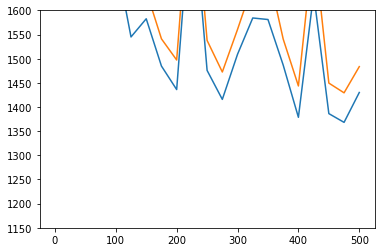

In [12]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(1150, 1600)

## Obtaining the posterior object and sample latent space as well as imputation from it

The posterior object contains a model and a gene_dataset, as well as additional arguments that for Pytorch's `DataLoader`. It also comes with many methods or utilities querying the model, such as differential expression, imputation and differential analyisis.


To get an ordered output result, we might use `.sequential` posterior's method which return another instance of posterior (with shallow copy of all its object references), but where the iteration is in the same ordered as its  indices attribute.

In [49]:
full = trainer.create_posterior(trainer.model, gene_dataset, indices=np.arange(len(gene_dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

In [52]:
latent.shape

(3005, 10)

In [56]:
all(batch_indices==0)

True

Similarly, it is possible to query the imputed values via the `imputation` method of the posterior object. **Note for advanced users:** imputation is an ambiguous term and there are two ways to perform imputation in scVI. The first way is to query the **mean of the negative binomial** distribution modeling the counts. This is referred to as `sample_rate` in the codebase and can be reached via the `imputation` method. The second is to query the **normalized mean of the same negative binomial** (please refer to the scVI manuscript). This is referred to as `sample_scale` in the codebase and can be reached via the `get_sample_scale` method. In differential expression for example, we of course rely on the normalized latent variable which is corrected for variations in sequencing depth.

In [58]:
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()

In [64]:
normalized_values[0:10,0:10]

array([[1.21142730e-01, 8.02836672e-04, 1.20084942e-03, 5.17982664e-03,
        4.64678800e-04, 1.19259581e-02, 7.45189749e-03, 7.95472600e-03,
        2.01866220e-04, 1.15508796e-03],
       [2.25159138e-01, 4.33410576e-04, 1.55270693e-03, 5.52556477e-03,
        3.68946203e-04, 1.44970715e-02, 6.49120333e-03, 1.08849006e-02,
        9.16327335e-05, 1.13110500e-03],
       [1.38555661e-01, 6.52494375e-04, 9.11981275e-04, 4.17196145e-03,
        2.85375194e-04, 1.14391549e-02, 9.68025345e-03, 1.00142928e-02,
        1.44323436e-04, 7.09349755e-04],
       [1.49233326e-01, 6.15895726e-04, 1.21807773e-03, 4.24589682e-03,
        3.81797756e-04, 1.13233803e-02, 6.78523676e-03, 9.86594521e-03,
        1.47371029e-04, 9.73104849e-04],
       [7.40687400e-02, 9.89039778e-04, 7.38561794e-04, 2.38148146e-03,
        5.07006363e-04, 6.39413809e-03, 7.23963697e-03, 8.14943481e-03,
        2.76101317e-04, 8.93215474e-04],
       [1.23539560e-01, 7.49345287e-04, 9.17726604e-04, 3.83518520e-03,
   

In [65]:
gene_dataset._X[0:10,0:10]

array([[8.220e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.720e+02,
        1.800e+01, 1.210e+02, 0.000e+00, 0.000e+00],
       [8.690e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.800e+01, 6.800e+01, 0.000e+00, 0.000e+00],
       [1.237e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.200e+02,
        1.460e+02, 1.170e+02, 0.000e+00, 0.000e+00],
       [1.252e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        4.700e+01, 1.130e+02, 0.000e+00, 0.000e+00],
       [2.710e+02, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 8.600e+01, 0.000e+00, 0.000e+00],
       [6.310e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        8.200e+01, 6.300e+01, 0.000e+00, 0.000e+00],
       [9.860e+02, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.500e+01,
        6.600e+01, 1.040e+02, 0.000e+00, 0.000e+00],
       [2.080e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        6.900e+01, 7.200e+01, 0.000e+

## Visualizing the latent space with scanpy

scanpy is a handy and powerful python library for visualization and downstream analysis of single-cell RNA sequencing data. We show here how to feed the latent space of scVI into a scanpy object and visualize it using UMAP as implemented in scanpy. More on how scVI can be used with scanpy on [this notebook](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/scanpy_pbmc3k.ipynb). **Note to advanced users:** The code 'get_latent' returns only the mean of the posterior distribution for the latent space. However, we recover a full distribution with our inference framework. Let us keep in mind that the latent space visualized here is a practical summary of the data only. Uncertainty is needed for other downstream analyses such as differential expression. 

In [11]:
import scanpy as sc
import anndata

In [12]:
post_adata = anndata.AnnData(X=gene_dataset.X)
post_adata.obsm["X_scVI"] = latent
post_adata.obs['cell_type'] = np.array([gene_dataset.cell_types[gene_dataset.labels[i][0]]  
                                        for i in range(post_adata.n_obs)])
sc.pp.neighbors(post_adata, use_rep="X_scVI", n_neighbors=15)
sc.tl.umap(post_adata, min_dist=0.1)

... storing 'cell_type' as categorical


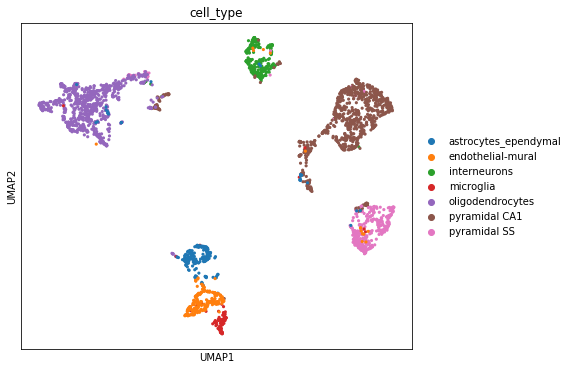

In [13]:
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(post_adata, color=["cell_type"], ax=ax, show=show_plot)

The user will note that we imported curated labels from the original publication. Our interface with scanpy makes it easy to cluster the data with scanpy from scVI's latent space and then reinject them into scVI for differential expression, which we now discuss.

In [ ]:
## 

# Understanding SCVI in Depth. Applications.

## Understanding Code for POSTERIOR OBJECT

### Understanding Posterior Initialize Method

In [22]:
GeneExpressionDataset = gene_dataset  # setting GeneExpressionDataset to None so that you can execute the cell
model = vae # setting model to None so that you can execute the cell
def __init__(
    self,
    model,
    gene_dataset: GeneExpressionDataset,
    shuffle=False,
    indices=None,
    use_cuda=True,
    data_loader_kwargs=dict(),
):

    """
    When added to annotation, has a private name attribute
    """

    self.model = model
    self.gene_dataset = gene_dataset
    self.to_monitor = []
    self.use_cuda = use_cuda


Every new class' constructor in Python starts with __init__ that initializes the class in a way that when creating the object from the class, gives the object access to the input variables, in this case `model`, `gene_dataset` etc.
The colon after `gene_dataset` refers to the default type of Gene Dataset which is `GeneExpressionDataset`, which is a module of `scvi.dataset`.
The posterior object may also make use of additional keyword arguments passed to the data loader, and these are initialized to be an empty dictionary at object creation time.
`Model`, `gene_dataset`, `cuda` arguments are saved to internal states of the `Posterior` object and `to_monitor` is initialized to an empty list.



In [69]:
!pwd
import os
os.chdir("/home/alaridl/pCloudDrive/W/dl_projects_combined/Modules/2_vi_scvi/")
import sys
sys.path.append("/home/alari/pCloudDrive/W/dl_projects_combined/Modules/2_vi_scvi/")
import scvi


/home/alaridl/pCloudDrive/W/dl_projects_combined/Modules/2_vi_scvi


The beginning of the class looks like the following:

In [74]:
class Posterior:
    def __init__(
        self,
        model,
        gene_dataset: GeneExpressionDataset,
        shuffle=False,
        indices=None,
        use_cuda=True,
        data_loader_kwargs=dict(),
    ):
        """

        When added to annotation, has a private name attribute
        """
        self.model = model
        self.gene_dataset = gene_dataset
        self.to_monitor = []
        self.use_cuda = use_cuda

        if indices is not None and shuffle:
            raise ValueError("indices is mutually exclusive with shuffle")
        if indices is None:
            if shuffle:
                sampler = RandomSampler(gene_dataset)
            else:
                sampler = SequentialSampler(gene_dataset)
        else:
            if hasattr(indices, "dtype") and indices.dtype is np.dtype("bool"):
                indices = np.where(indices)[0].ravel()
            sampler = SubsetRandomSampler(indices)
        self.data_loader_kwargs = copy.copy(data_loader_kwargs)
        self.data_loader_kwargs.update(
            {"collate_fn": gene_dataset.collate_fn_builder(), "sampler": sampler}
        )
        self.data_loader = DataLoader(gene_dataset, **self.data_loader_kwargs)


If user provides what indices to use in the posterior, then the data cannot be shuffled, this is what the first exception is for; otherwise if user does not provide indices (i.e. they are none, their default value), then a sampler is used for shuffling the data.

By analyzing the `posterior.py` file carefully, we notice that all these samplers are Pytorch modules, as defined by

```python
from torch.utils.data.sampler import (
    SequentialSampler,
    SubsetRandomSampler,
    RandomSampler,
)
```

If the user has provided indices for the Posterior object, then the `hasattr` method checks whether the indices have a `dtype` attribute. The `dtype` attribute is present whenever the indices is a Numpy array. Let's verify this.

In [76]:
import numpy as np
b = [1,2,3]
a = np.array(b)

if hasattr(a,"dtype"):
    print("A generic numpy array has dtype attribute")
else :
       print("A generic numpy array does not have  dtype attribute")
        
if hasattr(b,"dtype"):
    print("Python list has dtype attribute")
else :
       print("Python list does not have  dtype attribute")

A generic numpy array has dtype attribute
Python list does not have  dtype attribute


So we see indeed that Numpy arrays have `dtype` attribute while Python lists don't. Next the method checks whether the dtype is `bool`, meaning `True` or `False`. If so, then numpy's `where` method  is used to find the `True` indices and flatten the resulting array.

In [86]:
indices = np.array([True,False,True,False])
if hasattr(indices, "dtype") and indices.dtype is np.dtype("bool"):
    print("The constructed boolean array has correct format for the method")
    indices = np.where(indices)[0].ravel()
    print(f"Now the indices look like {indices}, since \n \
          ravel where extracts the True indices and ravel flattens the Numpy array, \n \
          causing it to be 1-dimensional")
else :
    print("The constructed boolean array does not have  correct format for the method")
#indices = np.where(indices)[0].ravel()


The constructed boolean array has correct format for the method
Now the indices look like [0 2], since 
           ravel where extracts the True indices and ravel flattens the Numpy array, 
           causing it to be 1-dimensional


Note that whereas Python lists don't have an inbuilt flatten method, but when using Numpy arrays, we will be equipped with the `ravel` method. Numpy arrays are also optimized for computing operations, making numerical calculations faster.

Nex the sampler is defined using `SubsetRandomSampler` from Pytorch. By going to [the source code](https://pytorch.org/docs/stable/_modules/torch/utils/data/sampler.html#SubsetRandomSampler), we see that
>> `SubsetRandomSampler` Samples elements randomly from a given list of indices, without replacement.

Internally it means that the `__iter__` method is defined as to make the `sampler` object iterable.

```python
(self.indices[i] for i in torch.randperm(len(self.indices)))
```
This means that the indices are randomly permuted and once an index has been selected, it cannot be selected again, since the sampling is without replacement.


Next we see an interesting `copy.copy()` construct. What could that mean?

By going to [Python manual page for that submodule](https://docs.python.org/3/library/copy.html)
, we can see the following:
    
> Assignment statements in Python do not copy objects, they create bindings between a target and an object. For collections that are mutable or contain mutable items, a copy is sometimes needed so one can change one copy without changing the other. This module provides generic shallow and deep copy operations (explained below).

```python
copy.copy(x)
```
Return a shallow copy of x.
In this case, the idea is to copy the `data_loader_kwargs` to the internal (or `self`) state of the `Posterior` object. If `data_loader_kwargs` are changed, then since the code

```python
self.data_loader_kwargs = copy.copy(data_loader_kwargs)
```
only uses a shallow copy to the kwargs, the internal state in Posterior is not changed.

#### Collate function for `Posterior`

```python
self.data_loader_kwargs.update(
            {"collate_fn": gene_dataset.collate_fn_builder(), "sampler": sampler}
        )
```

Can you guess what is the role of the previous code chunk?
Every dictionary in Python has an `update` method. Let's verify this


In [97]:
k = dict()
if hasattr(k,"items"):
    print("A generic dictionary in Python has items attribute")
if hasattr(k,"update"):
    print("A generic dictionary in Python has update attribute")
 
    

A generic dictionary in Python has items attribute
A generic dictionary in Python has update attribute


<function dict.items>

So we can see that we can also check the presence of methods with the `hasattr` function and the same way every dictionary in Python has `items`, it also has an `update` method to update items (i.e. to change or add items in the dictionary).


 In this case, the previously discussed sampler is saved and and a gene datasets
`collate_fn_builder` is called. Let's analyze what this method does. 
 
```python
def collate_fn_base(
    self, attributes_and_types: Dict[str, type], batch: Union[List[int], np.ndarray]
) -> Tuple[torch.Tensor, ...]:
    """Given indices and attributes to batch, returns a full batch of ``Torch.Tensor``"""
    indices = np.asarray(batch)
    data_numpy = [
        getattr(self, attr)[indices].astype(dtype)
        if isinstance(getattr(self, attr), np.ndarray)
        else getattr(self, attr)[indices].toarray().astype(dtype)
        for attr, dtype in attributes_and_types.items()
    ]

    data_torch = tuple(torch.from_numpy(d) for d in data_numpy)
    return data_torch

```



First we might notice constructs like Dict, Union, List, Tuple.
What are these?
When we browser the code for `dataset.py`, we can notice the following import
```python
from typing import Dict, Iterable, List, Tuple, Union, Optional, Callable
```


That means that from `typing` module we have imported the mentioned set of submodules.
[This Stackoverflow topic](https://stackoverflow.com/questions/32557920/what-are-type-hints-in-python-3-5) explains well why these type hint constructs exist:

> Due to the dynamic nature of Python, inferring or checking the type of an object being used is especially hard. This fact makes it hard for developers to understand what exactly is going on in code they haven't written and, most importantly, for type checking tools found in many IDEs [PyCharm, PyDev come to mind] that are limited due to the fact that they don't have any indicator of what type the objects are. As a result they resort to trying to infer the type with (as mentioned in the presentation) around 50% success rate.

Thus we can use the explicit constructs that denote the respective data types in Python.

Let's take a look at an example

In [ ]:
movie = {'name': 'Blade Runner',
         'year': 1982}

import typing
from typing import TypedDict

class Movie(TypedDict):
    name: str
    year: int

movie: Movie = {'name': 'Blade Runner',
                'year': 1982}
#That quantifies that now the object movie is of Movie type.

#### Collate Function Base

```python
def collate_fn_base(
    self, attributes_and_types: Dict[str, type], batch: Union[List[int], np.ndarray]
    ) -> Tuple[torch.Tensor, ...]:
```
This construct means that the base collate function takes in two arguments(`attributes_and_types`and `batch`)
and returns a Tuple of `torch.tensor` types.
The `attributes_and_types` Dictionary has both `str` and `type`. What are these? Since a dictionary is of `Mapping`, it specifies the data types of both the key and the value. For more information and examples, refer to [this source](https://mypy.readthedocs.io/en/latest/cheat_sheet_py3.html).
Batch is defined as a `Union` of an integer list and `numpy ndarray`.

```python
 """Given indices and attributes to batch, returns a full batch of ``Torch.Tensor``"""
    indices = np.asarray(batch)
    data_numpy = [
        getattr(self, attr)[indices].astype(dtype)
        if isinstance(getattr(self, attr), np.ndarray)
        else getattr(self, attr)[indices].toarray().astype(dtype)
        for attr, dtype in attributes_and_types.items()
    ]

    data_torch = tuple(torch.from_numpy(d) for d in data_numpy)
    return data_torch
```   
Firstly, the batch that was a `Union` of `List` and `ndarray` is converted into a `numpy array`. Then the `attributes_and_types` dictionary, that has all the attributes and their types, is looped over. If the attribute is of `ndarray` type then the attribute (any of
 > ("dataset_versions",
"gene_attribute_names",
"cell_attribute_names",
"cell_categorical_attribute_names",
"cell_measurements_columns") 

 or
 
> ("X", 
"corrupted_X",
"local_means",
"local_vars",
"batch_indices",
"labels")


of the respective indices are selected and converted to the defined `dtype`, otherwise if the attribute is not of `ndarray` type, then it is first converted to `ndarray` type and then converted, the resulting variable is called `data_numpy`.

Lastly, the following Python code converts the `data_numpy` to tuple of Torch Tensors, where each Tensor contains a list of defined attribute values. As the documentation specifies, the one return statement corresponds to one `batch` of data (not the whole dataset).

Thus the `collate_fn_base` is concluded and we can start analyzing the `collate_fn_builder`

```python
def collate_fn_builder(
    self,
    add_attributes_and_types: Dict[str, type] = None,
    override: bool = False,
    corrupted=False,
) -> Callable[[Union[List[int], np.ndarray]], Tuple[torch.Tensor, ...]]:
    """Returns a collate_fn with the requested shape/attributes"""

    if override:
        attributes_and_types = dict()
    else:
        attributes_and_types = dict(
            [
                ("X", np.float32) if not corrupted else ("corrupted_X", np.float32),
                ("local_means", np.float32),
                ("local_vars", np.float32),
                ("batch_indices", np.int64),
                ("labels", np.int64),
            ]
        )

    if add_attributes_and_types is None:
        add_attributes_and_types = dict()
    attributes_and_types.update(add_attributes_and_types)
    return partial(self.collate_fn_base, attributes_and_types)
```   



The collate function builder returns a partial function of the base collate function. What is a partial function you might ask?

[interactive source on partial functions](https://www.learnpython.org/en/Partial_functions)
Thus as you can read, partial function enables a user to make specific "caller functions" of existing functions with some argument set to some default value. For example a `multiply` function that has two arguments could be made into a partial function that only accepts one argument while the other is set to 2, thus every call of this function will return the double the number given to it.

If override argument is set to True, the attributes and types dictionary is overwritten with an empty dictionary, otherwise the following items are used :

 > ("X", np.float32) if not corrupted else ("corrupted_X", np.float32),
("local_means", np.float32),
("local_vars", np.float32),
("batch_indices", np.int64),
("labels", np.int64),
]

These quantify the gene activation data (without noise, or if corrupted, then with noise), local means and variances, indices for the batches as well as the cell labels.
If additional attributes and types are not None, then these are also added to the dictionary.
Lastly, the partial function of the base collate function is returned with the defined `attributes_and_types`. 




#### Recap of `collate_fn_builder` , Finishing Posterior Initialization

This function enables the user to do multiple things:
> 1. First it enables the user to add additional attributes to the data
> 2. Secondly, it allows to corrupt the data (making use of `corrupted_X` variable.
> 3. Thirdly, it allows to clear the attributes (`override=True`).

You might think why does all this matter?
**It all comes together for the purpose of `data_loader`.**
The Pytorch `data_loader` takes more arguments than just the gene dataset. In addition to the original dataset, we also need attributes, labels and parameters that relate to learning the structure of the data -- this was all achieved through the `collate_fn_builder` that is passed to Pytorch DataLoader. In addition to that, we know that passing the data should not be biased, otherwise if the dataset had some kind of intrinsic ordering and we only passed the say the first 1000 lines of the dataset, then the neural network would not learn anything useful about the whole data but only memorize a small portion of it. Thus, the Pytorch data loader also receives the sampler that gives a random permutation of the underlying (attribute) data.

Thus, to finish off the `Posterior` class initialization, the last line states
```python
self.data_loader = DataLoader(gene_dataset, **self.data_loader_kwargs)
```   




## Understanding Posterior Class Methods.

The relevant methods for understanding Differential Expression are:
> 1. `differential_expression_score` , extension of 1.
> 2. Mathematics oriented lower level methods `elbo` ,`reconstruction_error` , `marginal_ll`, `get_latent`
> 4. Other methods to understand the `Posterior` class



### Posterior Scale Sampler Method

```python
idx1: Union[List[bool], np.ndarray],
idx2: Union[List[bool], np.ndarray],
batchid1: Optional[Union[List[int], np.ndarray]] = None,
batchid2: Optional[Union[List[int], np.ndarray]] = None,
use_observed_batches: Optional[bool] = False,
n_samples: int = 5000
eps = 1e-8  # used for numerical stability
        # Normalized means sampling for both populations
        scales_batches_1 = self.scale_sampler(
            selection=idx1,
            batchid=batchid1,
            use_observed_batches=use_observed_batches,
            n_samples=n_samples,
        )
        scales_batches_2 = self.scale_sampler(
            selection=idx2,
            batchid=batchid2,
            use_observed_batches=use_observed_batches,
            n_samples=n_samples,
        )
```

Full Indices and batch indices for 2 cell populations 1 and 2 are assumed to be given by a union of boolean values 
and an `ndarray`.
Given the selection of indices,  whether to use observed batches or not and the amount of samples to use, using the `scale_sampler` we can obtain the normalized means sampling for both cell populations as well as the batch indices.
Let us analyze the scale sampler in full depth.




The docstring is the following:
```python
   """
        :param n_samples: Number of samples in total per batch (fill either `n_samples_total`
        or `n_samples_per_cell`)
        :param n_samples_per_cell: Number of time we sample from each observation per batch
        (fill either `n_samples_total` or `n_samples_per_cell`)
        :param batchid: Biological batch for which to sample from.
        Default (None) sample from all batches
        :param use_observed_batches: Whether normalized means are conditioned on observed
        batches or if observed batches are to be used
        :param selection: Mask or list of cell ids to select
        :return:
        Dictionary containing:
            `scale`
                Posterior aggregated scale samples of shape (n_samples, n_genes)
                where n_samples correspond to either:
                - n_bio_batches * n_cells * n_samples_per_cell
                or
                 - n_samples_total
            `batch`
                associated batch ids

        """
```


The Posterior `scale_sampler` method works the following way:
```python
# Get overall number of desired samples and desired batches
    if batchid is None and not use_observed_batches:
        batchid = np.arange(self.gene_dataset.n_batches)
    if use_observed_batches:
        assert batchid is None, "Unconsistent batch policy"
        batchid = [None]
    if n_samples is None and n_samples_per_cell is None:
        n_samples = 5000
    elif n_samples_per_cell is not None and n_samples is None:
        n_samples = n_samples_per_cell * len(selection)
    if (n_samples_per_cell is not None) and (n_samples is not None):
        warnings.warn(
            "n_samples and n_samples_per_cell were provided. Ignoring n_samples_per_cell"
        )
    n_samples = int(n_samples / len(batchid))
    if n_samples == 0:
        warnings.warn(
            "very small sample size, please consider increasing `n_samples`"
        )
        n_samples = 2
``` 
- If user has not provided batch indices and `use_observed_batches` is `False`, then all the batch indices up to the last index of the dadtaset `n_batches` are used.

- If `use_observed_batches` is `true` but no batch indices are provided, `batchid` (batch indices) are set to None.

- If the amount of samples and the amount of samples per cell are not provided, the amount of samples is set to 5000, 
otherwise if the amount of samples per cell is provided, but not the amount of samples, then the amount of samples is equal to the variable `selection` value is multiplied by the amount of samples per cell. Intuitively, the `selection` has to then correspond to the amount of cells.

- If  the amount of samples per cell exists, but the amount of samples per cell was not provided, a warning is given and the the amount of samples per cell is ignored. In this case, the amount of samples is computed as the the amount of samples over the amount of batches, thus this variable effectively becomes the **amount of samples per batch**.

- In case the amount of samples is much smaller than the amount of batch indices, then the `n_samples` or the amount of samples per batch is set to 2. 





Now that the `n_samples` is set, the method continues in this way:
```python
# Selection of desired cells for sampling
if selection is None:
    raise ValueError("selections should be a list of cell subsets indices")
selection = np.array(selection)
if selection.dtype is np.dtype("bool"):
    selection = np.asarray(np.where(selection)[0].ravel())
old_loader = self.data_loader

# Sampling loop
px_scales = []
batch_ids = []
for batch_idx in batchid:
    idx = np.random.choice(
        np.arange(len(self.gene_dataset))[selection], n_samples
    )
    self.update_sampler_indices(idx=idx)
    px_scales.append(self.get_sample_scale(transform_batch=batch_idx))
    batch_ids.append(np.ones((px_scales[-1].shape[0])) * batch_idx)
px_scales = np.concatenate(px_scales)
batch_ids = np.concatenate(batch_ids).reshape(-1)
assert (
    px_scales.shape[0] == batch_ids.shape[0]
), "sampled scales and batches have inconsistent shapes"
self.data_loader = old_loader
return dict(scale=px_scales, batch=batch_ids)
```
- If a user has not selected the cells to compare, an error is thrown because the subset of cells to analyze has not been defined. Otherwise, the selection is converted into numpy array, which can also be a `boolean` array. In this case, the `boolean` values are used to select the subset where the boolean value is `True` .

- A pointer to the `data_loader` that was obtained by the end of the `Posterior` class initialization is saved to the variable `old_loader`.

Then:

- For each batch, random sample, with max index equal to length of selection (thus cannot generate indices out of the selection) and size equal to `n_samples` (remember that this variable is equal to the amount of samples per batch, thus we do this operation for each batch).

- The sample indices are updated. As seen from below, that means generating a new sampler with these indices and then updating the Pytorch `data_loader` of the `Posterior` object with this new sampler.
```python
sampler = SubsetRandomSampler(idx)
self.data_loader_kwargs.update({"sampler": sampler})
self.data_loader = DataLoader(self.gene_dataset, **self.data_loader_kwargs)
```
- `get_sample_scale` method is used to update the scales. The relevant methods in this case are:

```python
 def __iter__(self):
        return map(self.to_cuda, iter(self.data_loader))
    
def get_sample_scale(self, transform_batch=None):
    px_scales = []
    for tensors in self:
        sample_batch, _, _, batch_index, labels = tensors
        px_scales += [
            np.array(
                (
                    self.model.get_sample_scale(
                        sample_batch,
                        batch_index=batch_index,
                        y=labels,
                        n_samples=1,
                        transform_batch=transform_batch,
                    )
                ).cpu()
            )
        ]
    return np.concatenate(px_scales)
```

The method returns the tensors of predicted frequencies of expression for all batches concatenated. The model method is documented [on the documentation website](https://scvi.readthedocs.io/en/latest/scvi.models.html#scvi.models.VAE.get_sample_scale).


### What is Returned from `scale_sampler` Posterior Method
     
The `scale_sampler` method returns then the dictionary of gene expression frequencies, derived from `Posterior` inference together with the batch indices.

If you didn't understand the ending of the last code chunk with arrays and lists, don't worry, let's try out an example in Python

In [21]:
a = [np.array([1,2,3])]
b = [np.array([4,5,6])]
c = []
c+=b
c+=a
print(c)
np.concatenate(c)

[array([4, 5, 6]), array([1, 2, 3])]


array([4, 5, 6, 1, 2, 3])

You can see that the `Posterior's ` `get_sample_scale` method calls the same method of the model, processing one data batch of tensors at a time. Inside the method, posterior inference for the model is performed, meaning that latent samples are drawn from the latent distributions and using decoders, these are mapped back to the original space. Let's look at this process more closely.

As seen from the `__iter__` method, the `tuple` of Pytorch `data batch` tensors are first mapped to the `CUDA` device if it exists. Then the `Posterior` object becomes an iterable, thus we can iterate over the batches in the `get_sample_scale` loop.
As you remember from the `collate_fn_builder`, the `attributes_and_types` look the following:

>     ("X", np.float32) if not corrupted else ("corrupted_X", np.float32),
                ("local_means", np.float32),
                ("local_vars", np.float32),
                ("batch_indices", np.int64),
                ("labels", np.int64),
            ]
 
 - For every data attributes batch:
     - Unpack the batch itself, the batch index and labels, don't use the other variables
     - Call the `model's` `get_sample_scale_method` that concatenates the vector of gene expression frequencies across all batches., to the `px_scales` variable. In this case, the model may be for example a variational autoencoder. 
     

#### Getting Sample Scale from the (Variational Autoencoder) Model (Posterior Inference)

```python
 def get_sample_scale(
        self, x, batch_index=None, y=None, n_samples=1, transform_batch=None
    ):
        r"""Returns the tensor of predicted frequencies of expression

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :param batch_index: array that indicates which batch the cells belong to with shape ``batch_size``
        :param y: tensor of cell-types labels with shape ``(batch_size, n_labels)``
        :param n_samples: number of samples
        :param transform_batch: int of batch to transform samples into
        :return: tensor of predicted frequencies of expression with shape ``(batch_size, n_input)``
        :rtype: :py:class:`torch.Tensor`
        """
        return self.inference(
            x,
            batch_index=batch_index,
            y=y,
            n_samples=n_samples,
            transform_batch=transform_batch,
        )["px_scale"]
``` 
We can see that the posterior inference method takes in a batch of gene expression data where the `n_input` is equal to the columns of the previously defined `sample_batch`. The other inputs should be straightforward to understand.
However, the beginning of the **posterior inference** method is more complex:

```python
    def inference(self, x, batch_index=None, y=None, n_samples=1, transform_batch=None):

        x_ = x
        if self.log_variational:
            x_ = torch.log(1 + x_)

        # Sampling
        qz_m, qz_v, z = self.z_encoder(x_, y)
        ql_m, ql_v, library = self.l_encoder(x_)

```
In short, this is the crux of the `variational autoencoder` or similar models.
The gene expression data is put through through first the `encoder`s that compress the data. The difference from a normal `autoencoder` is that the `encoder` neurons actually represent the parameters of **normal distribution**, that is mean and variance vectors. Different from a simple `variational_autoencder`, there are two encoders -- `l_encoder` and `z_encoder`.

Let's see what's the difference:


```python
 # z encoder goes from the n_input-dimensional data to an n_latent-d
        # latent space representation
        self.z_encoder = Encoder(
            n_input,
            n_latent,
            n_layers=n_layers,
            n_hidden=n_hidden,
            dropout_rate=dropout_rate,
        )
        # l encoder goes from n_input-dimensional data to 1-d library size
        self.l_encoder = Encoder(
            n_input, 1, n_layers=1, n_hidden=n_hidden, dropout_rate=dropout_rate
        )
 
class Encoder(nn.Module):
    r"""Encodes data of ``n_input`` dimensions into a latent space of ``n_output``
    dimensions using a fully-connected neural network of ``n_hidden`` layers.

    :param n_input: The dimensionality of the input (data space)
    :param n_output: The dimensionality of the output (latent space)
    :param n_cat_list: A list containing the number of categories
                       for each category of interest. Each category will be
                       included using a one-hot encoding
    :param n_layers: The number of fully-connected hidden layers
    :param n_hidden: The number of nodes per hidden layer
    :dropout_rate: Dropout rate to apply to each of the hidden layers
    """

    def __init__(self, n_input: int, n_output: int,
                 n_cat_list: Iterable[int] = None, n_layers: int = 1,
                 n_hidden: int = 128, dropout_rate: float = 0.1):
        super(Encoder, self).__init__()

        self.encoder = FCLayers(n_in=n_input, n_out=n_hidden, n_cat_list=n_cat_list, n_layers=n_layers,
                                n_hidden=n_hidden, dropout_rate=dropout_rate)
        self.mean_encoder = nn.Linear(n_hidden, n_output)
        self.var_encoder = nn.Linear(n_hidden, n_output)

    
``` 

From here we see that both the `z_encoder` and `l_encoder` make use of the same `Encoder` class, with the only difference that the `l_encoder` compresses the data to be 1-dimensional, thus just 1 mean and 1 variance (1-D Gaussian).

#### Understanding What the Encoder Really Does -- Core Difference Between Autoencoder and Variational Autoencoder

```python
def reparameterize(self, mu, var):
        return Normal(mu, var.sqrt()).rsample()

def forward(self, x: torch.Tensor, *cat_list: int):
    r"""The forward computation for a single sample.

     #. Encodes the data into latent space using the encoder network
     #. Generates a mean \\( q_m \\) and variance \\( q_v \\) (clamped to \\( [-5, 5] \\))
     #. Samples a new value from an i.i.d. multivariate normal \\( \\sim N(q_m, \\mathbf{I}q_v) \\)

    :param x: tensor with shape (n_input,)
    :param cat_list: list of category membership(s) for this sample
    :return: tensors of shape ``(n_latent,)`` for mean and var, and sample
    :rtype: 3-tuple of :py:class:`torch.Tensor`
    """

    # Parameters for latent distribution
    q = self.encoder(x, *cat_list)
    q_m = self.mean_encoder(q)
    q_v = torch.exp(self.var_encoder(q))  # (computational stability safeguard)torch.clamp(, -5, 5)
    latent = self.reparameterize(q_m, q_v)
    return q_m, q_v, latent
```
As explained in the previous notebooks and materials, the core difference between variational autoencoder and "ordinary" autoencoder is that the encoder neurons in the variational autoencoder represent the parameters of the latent distribution. 
Understanding the `Encoder`:
>1. First the data is put through Fully Connected Layers (`FCLayers`), where every neuron in the input layer is connected to every neuron in the output layer (similar to a `Hopfield network`). Some of the neural connections are not always used due to the dropout probability that set some weights to 0 with `dropout_rate` probability. 
> 2. Then the resulting data is put through the `mean_encoder` which is just takes a linear combination of the data times the weights between the fully connected and output layer, for each output neuron. The result is a mean vector with `n_output` elements.
> 3. In getting the variance vector of the latent normal distribution, we assume that the network actually encoders the logarithm of the variance. To find the variance, the resulting variance vector is element-wise exponentiated. To understand why logarithm of the variance is modeled, please refer to [this topic](https://stats.stackexchange.com/questions/353220/why-in-variational-auto-encoder-gaussian-variational-family-we-model-log-sig)
>4. To actually get the latent distribution, the before calculated mean and variance are used to draw a random sample from I.I.D. Multivariate Normal distribution with 0 non-diagonal covariances (thus the hyperellipsoids are aligned with the coordinate axes, and don't have any rotational component, so to say). This is the famous scale-location Reparametrization trick as the sampling is always differentiable w.r.t. to standard normal multivariate distribution, encoded in the variable $\epsilon$ for which the parameters  never change, and a deterministic variable $g(.)  = location + scale \times \epsilon$ than then transforms the Gaussian to arbitrary mean vector and covariances. That means that Pytorch as an autograd framework is always able to compute the gradients w.r.t. to the parameters of the latent distribution in the gradient descent type of optimization as the parameters of the distribution we actually sample from never change.
> 5. The encoder returns the mean and variance vectors of the latent distribution as well as the latent distribution values itself.


In [14]:
import torch
x = torch.tensor([1, 2, 3, 4])
print(x.shape)
x = x.unsqueeze(0).expand(10,x.size(0),x.size(1))
print(x.shape)

torch.Size([4])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

### What can we Do Once the Variational Autoencoder is Trained?

The full strength of Bayesian inference is that not only do we get the point estimates for predictions, but also the confidence intervals or uncertainties around the predictions. That is the benefit of having the full posterior distribution of the parameters available. 

The **training in classical machine learning corresponds to updating the prior distribution of parameters with data** (*remember: in Bayesian Inference, the data is fixed and model parameters are dynamic or random*). That means that in frequentist machine learning, the model and its parameters are deterministic since we don't consider any probability distribution over the parameters. Although the model training is stochastic (due to the different possible starting guesses), the model itself is deterministic -- there is only one prediction without any confidence or uncertainty.
In contrast, in Bayesian Machine Learning, the model parameters through the posterior distribution change with every pass as the distribution changes shape until it converges to some known distribution. Data on the other hand is considered fixed. In Bayesian Machine Learning, the distribution of the data is called the `evidence` and this is just a normalization term in the Bayes formula that is determined by all possible values of the distribution parameters (in integral form)

### Bayesian Machine Learning VS Frequentist Machine Learning

>1. Bayesian machine learning works with any data size, but frequentist machine learning works only for `big data` (when the numbers of data points is much bigger than the amount of parameters). Be cautious since neural networks often have millions of parameters.

> 2. In Bayesian machine learning, parameters are random and data is fixed; in frequentist machine learning it's the opposite. That results in Bayesian machine learning to be able to quantify uncertainty around the predictions and to generate new data points, as the distribution of the data (evidence) can be directly computed.
> 3. In Frequentist machine learning, a model is trained using the MLE (Maximum Likelihood) principle with the goal to find the parameters $\theta$ that maximize the likelihood of observing the measured data, given the parameters. In contrast, in Bayesian machine learning, training results in the computation of the posterior distribution of parameters given the data.
That posterior distribution is then directly used in the prediction on the test set through the marginalization principle as follows:
![marginalization_principle](https://filedn.com/lK1VhM9GbBxVlERr9KFjD4B/pictures_to_use_in_bayesian_module/bayestraining.JPG)

#### Resuming the Analysis of the Posterior Inference `scale_sampler` method

Remember that `get_sample_scale` method defined that for each batch in the tensors, model's `get_sample_scale` method was called, in which the posterior inference on that batch was performed.
Previously we have analyzed the `encoder` part. Let's see what happens after the encoder.

```python
  if n_samples > 1:
            qz_m = qz_m.unsqueeze(0).expand((n_samples, qz_m.size(0), qz_m.size(1)))
            qz_v = qz_v.unsqueeze(0).expand((n_samples, qz_v.size(0), qz_v.size(1)))
            z = Normal(qz_m, qz_v.sqrt()).sample()
            ql_m = ql_m.unsqueeze(0).expand((n_samples, ql_m.size(0), ql_m.size(1)))
            ql_v = ql_v.unsqueeze(0).expand((n_samples, ql_v.size(0), ql_v.size(1)))
            library = Normal(ql_m, ql_v.sqrt()).sample()

        if transform_batch is not None:
            dec_batch_index = transform_batch * torch.ones_like(batch_index)
        else:
            dec_batch_index = batch_index

        px_scale, px_r, px_rate, px_dropout = self.decoder(
            self.dispersion, z, library, dec_batch_index, y
        )
        if self.dispersion == "gene-label":
            px_r = F.linear(
                one_hot(y, self.n_labels), self.px_r
            )  # px_r gets transposed - last dimension is nb genes
        elif self.dispersion == "gene-batch":
            px_r = F.linear(one_hot(dec_batch_index, self.n_batch), self.px_r)
        elif self.dispersion == "gene":
            px_r = self.px_r
        px_r = torch.exp(px_r)

        return dict(
            px_scale=px_scale,
            px_r=px_r,
            px_rate=px_rate,
            px_dropout=px_dropout,
            qz_m=qz_m,
            qz_v=qz_v,
            z=z,
            ql_m=ql_m,
            ql_v=ql_v,
            library=library,
        )
    
```
Since the `posterior_inference` was called in a loop over all the batches and `n_samples` quantified  the amount of samples per batch, thus we need to extend the mean and variance tensors to be 3-dimensional to accommodate multiple samples per batch. This is achieved through the `unsqueeze` and `expand` commands. `unsqueeze` creates adds new dimension to 0-axis, and `expand` fills that dimension with the additional sample data, essentially repeating the same arrays `n_samples` times. To read more about these commands, refer [unsqueeze source](https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch) and [expand source](https://discuss.pytorch.org/t/torch-repeat-and-torch-expand-which-to-use/27969).
The same is done for `l_encoder` and `z_encoder` outputs. The amount of latent variable values drawn is equal to `n_samples`, so if it is greater than one, then multiple values from multivariate normal i.i.d. distribution are drawn, otherwise only one sample is drawn. The results from that processing step are two variables `z` that is a latent vector (with `n_hidden` dimensions) and `library` that is a 1D latent vector.

Next, the SCVI Decoder is used to obtained the Zero-inflated negative binomial distribution parameters. Remember that the initial data input to the variational autoencoder quantifies the count readings of genes in cells or frequencies, then the `px_scale` vector is obtained through the following code:

```python
self.px_scale_decoder = nn.Sequential(nn.Linear(n_hidden, n_output), nn.Softmax(dim=-1))
``` 
Thus, the `px_scale_decoder`is a sequential application of the linear layer and the `Softmax` layer and the dimension of this transformation is `n_samples` x `n_output`, where `n_samples` is the amount of samples per batch since inference is done per batch and the `n_output` is the amount of genes in the `gene_dataset` (gene expression matrix).

As in the `get_sample_scale` a loop over samples is run, where the scales from batches are concatenated to a list and finally `numpy.concatenate` is applied to the result over axis 0 (default axis), the result is a tensor of size `n_samples` x `n_output` of decoded `px_scale`tensor data, which is exactly the same shape as the input data, as is **supposed to be in the case of (variational) autoencoder**.


### Understanding the Meaning of the Softmax `px_scale` Tensor

To understand of the meaning of `px_scale` tensor, we have to look into the code of `SCVIDecoder`.

The Decoder used to map the latent sample back to the original gene expression space, quantifying the expression rate for each gene.

```python
class DecoderSCVI(nn.Module):
    r"""Decodes data from latent space of ``n_input`` dimensions ``n_output``
    dimensions using a fully-connected neural network of ``n_hidden`` layers.

    :param n_input: The dimensionality of the input (latent space)
    :param n_output: The dimensionality of the output (data space)
    :param n_cat_list: A list containing the number of categories
                       for each category of interest. Each category will be
                       included using a one-hot encoding
    :param n_layers: The number of fully-connected hidden layers
    :param n_hidden: The number of nodes per hidden layer
    :param dropout_rate: Dropout rate to apply to each of the hidden layers
    """

    def __init__(self, n_input: int, n_output: int,
                 n_cat_list: Iterable[int] = None, n_layers: int = 1,
                 n_hidden: int = 128):
        super(DecoderSCVI, self).__init__()
        self.px_decoder = FCLayers(n_in=n_input, n_out=n_hidden,
                                   n_cat_list=n_cat_list, n_layers=n_layers,
                                   n_hidden=n_hidden, dropout_rate=0)

        # mean gamma
        self.px_scale_decoder = nn.Sequential(nn.Linear(n_hidden, n_output), nn.Softmax(dim=-1))

        # dispersion: here we only deal with gene-cell dispersion case
        self.px_r_decoder = nn.Linear(n_hidden, n_output)

        # dropout
        self.px_dropout_decoder = nn.Linear(n_hidden, n_output)

    def forward(self, dispersion: str, z: torch.Tensor, library: torch.Tensor,
                *cat_list: int):
        r"""The forward computation for a single sample.

         #. Decodes the data from the latent space using the decoder network
         #. Returns parameters for the ZINB distribution of expression
         #. If ``dispersion != 'gene-cell'`` then value for that param will be ``None``

        :param dispersion: One of the following

            * ``'gene'`` - dispersion parameter of NB is constant per gene across cells
            * ``'gene-batch'`` - dispersion can differ between different batches
            * ``'gene-label'`` - dispersion can differ between different labels
            * ``'gene-cell'`` - dispersion can differ for every gene in every cell

        :param z: tensor with shape ``(n_input,)``
        :param library: library size
        :param cat_list: list of category membership(s) for this sample
        :return: parameters for the ZINB distribution of expression
        :rtype: 4-tuple of :py:class:`torch.Tensor`
        """

        # The decoder returns values for the parameters of the ZINB distribution
        px = self.px_decoder(z, *cat_list)
        px_scale = self.px_scale_decoder(px)
        px_dropout = self.px_dropout_decoder(px)
        # Clamp to high value: exp(12) ~ 160000 to avoid nans (computational stability)
        px_rate = torch.exp(library) * px_scale  # torch.clamp( , max=12)
        px_r = self.px_r_decoder(px) if dispersion == "gene-cell" else None
        return px_scale, px_r, px_rate, px_dropout
```

What happens here is that using the latent variable values derived from the initial gene expression matrix, parameters of the Zero-Inflated Negative Binomial Regression distribution are returned using the decoder. 

**The gene expression rate is calculated as the output from the `px_scale` that is the output of the following neural network layers : FC -> Linear -> Softmax. For each cell processed, the method returns the expression rate // frequency or probability for each gene.**

*Note that there are no one-hot-encoded variables in `Cortex Dataset`, thus `n_cat_list` is set to 0 in the decoder.*

## Differential Expression
**For more in-depth treatment, take a look at the next section**

From the trained VAE model we can sample the gene expression rate for each gene in each cell. For the two populations of interest, we can then randomly sample pairs of cells, one from each population to compare their expression rate for a gene. The degree of differential expression is measured by __logit(p/(1-p))__ where __p__ is the probability of a cell from population A having a higher expression than a cell from population B. We can form the null distribution of the DE values by sampling pairs randomly from the combined population.

The following example is implemented for the cortext dataset, vary __cell_types__ and __genes_of_interest__ for other datasets. 

**1. Set population A and population B for comparison**

In [72]:
cell_types = gene_dataset.cell_types
print(gene_dataset.cell_types)
# oligodendrocytes (#4) VS pyramidal CA1 (#5)
couple_celltypes = (4, 5)  # the couple types on which to study DE

print("\nDifferential Expression A/B for cell types\nA: %s\nB: %s\n" %
      tuple((cell_types[couple_celltypes[i]] for i in [0, 1])))

cell_idx1 = gene_dataset.labels.ravel() == couple_celltypes[0]
cell_idx2 = gene_dataset.labels.ravel() == couple_celltypes[1]

['astrocytes_ependymal' 'endothelial-mural' 'interneurons' 'microglia'
 'oligodendrocytes' 'pyramidal CA1' 'pyramidal SS']

Differential Expression A/B for cell types
A: oligodendrocytes
B: pyramidal CA1



In [71]:
cell_idx2.shape # boolean array indicating the correct cell locations over the dataset

(3005,)

**2. Define parameters**
* __n_samples__: the number of times to sample __px_scales__ from the vae model for each gene in each cell.
* __M_permutation__: Number of pairs sampled from the px_scales values for comparison.

In [68]:
n_samples = 100
M_permutation = 100000

In [69]:
de_res = full.differential_expression_score(
    cell_idx1, 
    cell_idx2, 
    n_samples=n_samples, 
    M_permutation=M_permutation,
)
de_res

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
PTGDS,1.00000,0.00000,18.420681,0.007664,0.000196,40.480488,0.942492,0.786585,0.064963,5.567890,0.067856
NPC2,0.99967,0.00033,8.016058,0.001938,0.000104,11.063415,0.636848,0.976829,0.302449,1.214167,0.049442
GATM,0.99952,0.00048,7.641224,0.002055,0.000175,12.093903,0.500533,0.976829,0.177849,1.360277,0.039960
ERMN,0.99935,0.00065,7.337873,0.005114,0.000248,28.808537,0.665602,0.970732,0.103301,3.075762,0.051155
ASPA,0.99925,0.00075,7.194674,0.002133,0.000122,12.009756,0.216187,0.909756,0.053248,1.391581,0.015937
...,...,...,...,...,...,...,...,...,...,...,...
GPM6A,0.00021,0.99979,-8.468145,0.000790,0.007530,3.813415,53.570820,0.587805,1.000000,0.421838,4.139109
PJA2,0.00021,0.99979,-8.468145,0.000435,0.002824,2.174390,22.217253,0.669512,1.000000,0.227136,1.713138
ATP6V1G2,0.00011,0.99989,-9.114829,0.000119,0.001179,0.419512,8.703940,0.173171,0.984026,0.039785,0.655106
TSPAN13,0.00004,0.99996,-10.126341,0.000222,0.003200,0.531707,22.612354,0.193902,0.996805,0.054707,1.726714


**3. Print out the differential expression value**
* bayes_factor: The bayes factor for cell type 1 having a higher expression than cell type 2
* raw_mean*i*: average UMI counts in cell type *i*
* non_zeros_proportion*i*: proportion of non-zero expression in cell type *i*
* raw_normalized_mean*i*: average UMI counts in cell type *i* normalized by cell size
* scale*i*: average scVI imputed gene expression scale in cell type *i* 


In [15]:
genes_of_interest = ["THY1", "MBP"]
de_res.filter(items=genes_of_interest, axis=0)

,proba_m1,proba_m2,bayes_factor,scale1,scale2,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2
THY1,0.00191,0.99809,-6.258735,0.000168,0.001827,0.589024,13.569755,0.219512,0.996805,0.060620,1.037373
MBP,0.99481,0.00519,5.255816,0.011276,0.000388,55.318295,2.787008,0.998780,0.452609,5.862774,0.210483


**9. Visualize top 10 most expressed genes per cell types**

In [16]:
per_cluster_de, cluster_id = full.one_vs_all_degenes(cell_labels=gene_dataset.labels.ravel(), min_cells=1)

markers = []
for x in per_cluster_de:
    markers.append(x[:10])
markers = pd.concat(markers)

genes = np.asarray(markers.index)
expression = [x.filter(items=genes, axis=0)['raw_normalized_mean1'] for x in per_cluster_de]
expression = pd.concat(expression, axis=1)
expression = np.log10(1 + expression)
expression.columns = gene_dataset.cell_types

[2019-11-13 16:19:18,878] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:18,909] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:18,940] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:18,970] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:19,000] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inference.posterior:Differential expression using vanilla mode
[2019-11-13 16:19:19,030] INFO - scvi.inference.posterior | Differential expression using vanilla mode
INFO:scvi.inferen

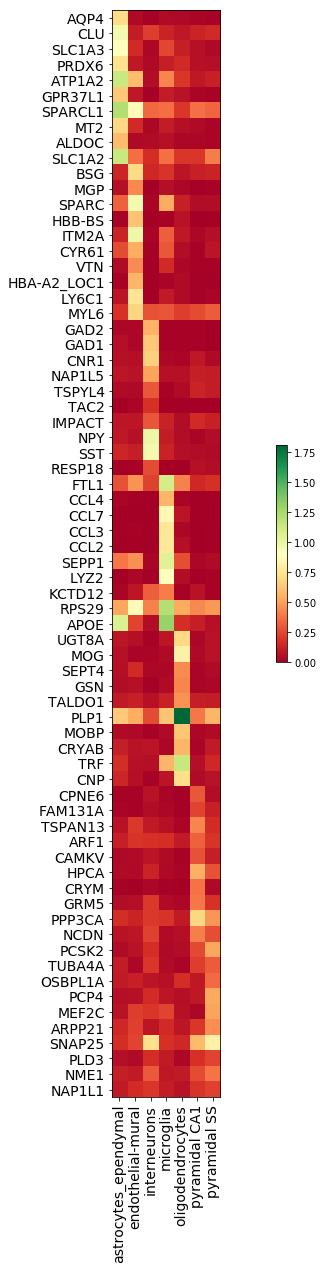

In [17]:
plt.figure(figsize=(20, 20))
im = plt.imshow(expression, cmap='RdYlGn', interpolation='none', aspect='equal')
ax = plt.gca()
ax.set_xticks(np.arange(0, 7, 1))
ax.set_xticklabels(gene_dataset.cell_types, rotation='vertical')
ax.set_yticklabels(genes)
ax.set_yticks(np.arange(0, 70, 1))
ax.tick_params(labelsize=14)
plt.colorbar(shrink=0.2)

### Understanding Differential Expression In-Depth

#### Pairs Sampler Method
The only method to cover before fully understanding `get_bayes_factors` method is the `pairs_sampler` method from `posterior_utils` submodule.

Given samples from 2 cell poplations, mixing parameters (`use_permutation`, `M_permutation`), `sanity_check_parameter` and sampling probability weights for both cell populations (`weights1`, `weights2`), 

returns the new arrays that have been modified by sampling probabilities and also permutation size parameter `M_permutation`, if relevant. 

```python
def pairs_sampler(
    arr1: Union[List[float], np.ndarray, torch.Tensor],
    arr2: Union[List[float], np.ndarray, torch.Tensor],
    use_permutation: bool = True,
    M_permutation: int = None,
    sanity_check_perm: bool = False,
    weights1: Union[List[float], np.ndarray, torch.Tensor] = None,
    weights2: Union[List[float], np.ndarray, torch.Tensor] = None,
) -> tuple:
    """
    In a context where we want to estimate a double sum, virtually increases the number
    of samples by considering more pairs so as to better estimate the double summation operation

    :param arr1: samples from population 1
    :param arr2: samples from population 2
    :param use_permutation: Whether to mix samples from both populations
    :param M_permutation:
    :param sanity_check_perm: If True, resulting mixed arrays arr1 and arr2 are mixed together
    In most cases, this parameter should remain False
    :param weights1: probabilities associated to array 1 for random sampling
    :param weights2: probabilities associated to array 2 for random sampling
    :return: new_arr1, new_arr2
    """
    if use_permutation is True:
        # prepare the pairs for sampling
        n_arr1 = arr1.shape[0]
        n_arr2 = arr2.shape[0]
        if not sanity_check_perm:
            # case1: no permutation, sample from A and then from B
            u, v = (
                np.random.choice(n_arr1, size=M_permutation, p=weights1),
                np.random.choice(n_arr2, size=M_permutation, p=weights2),
            )
            first_set = arr1[u]
            second_set = arr2[v]
        else:
            # case2: permutation, sample from A+B twice (sanity check)
            u, v = (
                np.random.choice(n_arr1 + n_arr2, size=M_permutation),
                np.random.choice(n_arr1 + n_arr2, size=M_permutation),
            )
            concat_arr = np.concatenate((arr1, arr2))
            first_set = concat_arr[u]
            second_set = concat_arr[v]
    else:
        first_set = arr1
        second_set = arr2
    return first_set, second_set

``` 

The core method to understand how the `differential_expression` works, is the `differential_expression_score`.
It is composed of 2 main methods : `differential_expression_stats` and `get_bayes_factors`.

```python
def differential_expression_score(self, cell_type, other_cell_type=None, genes=None,M_sampling=100,
M_permutation=10000, permutation=False):
    px_scale, all_labels = self.differential_expression_stats(M_sampling=M_sampling)
    cell_idx, other_cell_idx = self.gene_dataset._cell_type_idx([cell_type, other_cell_type])
    if genes is not None:
        px_scale = px_scale[:, self.gene_dataset._gene_idx(genes)]
    bayes_factors_list = get_bayes_factors(px_scale, all_labels, cell_idx, other_cell_idx=other_cell_idx,
                                           M_permutation=M_permutation, permutation=permutation)
    return bayes_factors_list
``` 

Let us first analyze the `differential_expression_stats`.

```python
def differential_expression_stats(self, M_sampling=100):
    """
    Output average over statistics in a symmetric way (a against b), forget the sets if permutation is True

    :param M_sampling: number of samplesdiff
    :return: Tuple px_scales, all_labels where (i) px_scales: scales of shape (M_sampling, n_genes)
        (ii) all_labels: labels of shape (M_sampling, )
    """
    warnings.warn(
        "differential_expression_stats() is deprecated; "
        "use differential_expression_score() or get_sample_scale().",
        category=DeprecationWarning,
    )

    px_scales = []
    all_labels = []
    batch_size = max(
        self.data_loader_kwargs["batch_size"] // M_sampling, 2
    )  # Reduce batch_size on GPU
    if len(self.gene_dataset) % batch_size == 1:
        batch_size += 1
    for tensors in self.update({"batch_size": batch_size}):
        sample_batch, _, _, batch_index, labels = tensors
        px_scales += [
            np.array(
                (
                    self.model.get_sample_scale(
                        sample_batch,
                        batch_index=batch_index,
                        y=labels,
                        n_samples=M_sampling,
                    )
                ).cpu()
            )
        ]

        # Align the sampling
        if M_sampling > 1:
            px_scales[-1] = (px_scales[-1].transpose((1, 0, 2))).reshape(
                -1, px_scales[-1].shape[-1]
            )
        all_labels += [np.array((labels.repeat(1, M_sampling).view(-1, 1)).cpu())]

    px_scales = np.concatenate(px_scales)
    all_labels = np.concatenate(all_labels).ravel()  # this will be used as boolean

    return px_scales, all_labels
```
The `differential_expression_stats` method

`get_bayes_factors` method:

```python
def get_bayes_factors(px_scale, all_labels, cell_idx, other_cell_idx=None, genes_idx=None,
                      M_permutation=10000, permutation=False):
    '''
    Returns a list of bayes factor for all genes
    :param px_scale: The gene frequency array for all cells (might contain multiple samples per cells)
    :param all_labels: The labels array for the corresponding cell types
    :param cell_idx: The first cell type population to consider. Either a string or an idx
    :param other_cell_idx: (optional) The second cell type population to consider. Either a string or an idx
    :param M_permutation: The number of permuted samples.
    :param permutation: Whether or not to permute.
    :return:
    '''
    idx = (all_labels == cell_idx)
    idx_other = (all_labels == other_cell_idx) if other_cell_idx is not None else (all_labels != other_cell_idx)
    if genes_idx is not None:
        px_scale = px_scale[:, genes_idx]
    sample_rate_a = px_scale[idx].reshape(-1, px_scale.shape[1])
    sample_rate_b = px_scale[idx_other].reshape(-1, px_scale.shape[1])

    # agregate dataset
    samples = np.vstack((sample_rate_a, sample_rate_b))

    # prepare the pairs for sampling
    list_1 = list(np.arange(sample_rate_a.shape[0]))
    list_2 = list(sample_rate_a.shape[0] + np.arange(sample_rate_b.shape[0]))
    if not permutation:
        # case1: no permutation, sample from A and then from B
        u, v = np.random.choice(list_1, size=M_permutation), np.random.choice(list_2, size=M_permutation)
    else:
        # case2: permutation, sample from A+B twice
        u, v = (np.random.choice(list_1 + list_2, size=M_permutation),
                np.random.choice(list_1 + list_2, size=M_permutation))

    # then constitutes the pairs
    first_set = samples[u]
    second_set = samples[v]

    res = np.mean(first_set >= second_set, 0)
    res = np.log(res + 1e-8) - np.log(1 - res + 1e-8)
    return res
```


 `differential_expression_score` and `one_vs_all_degenes` methods
 
```python
def differential_expression_score(
    self,
    idx1: Union[List[bool], np.ndarray],
    idx2: Union[List[bool], np.ndarray],
    mode: Optional[str] = "vanilla",
    batchid1: Optional[Union[List[int], np.ndarray]] = None,
    batchid2: Optional[Union[List[int], np.ndarray]] = None,
    use_observed_batches: Optional[bool] = False,
    n_samples: int = 5000,
    use_permutation: bool = True,
    M_permutation: int = 10000,
    all_stats: bool = True,
    change_fn: Optional[Union[str, Callable]] = None,
    m1_domain_fn: Optional[Callable] = None,
    delta: Optional[float] = 0.5,
) -> pd.DataFrame:
    r"""
    Unified method for differential expression inference.
    This function is an extension of the `get_bayes_factors` method
    providing additional genes information to the user

    # FUNCTIONING
    Two modes coexist:
        - the "vanilla" mode follows protocol described in arXiv:1709.02082
        In this case, we perform hypothesis testing based on:
            M_1: h_1 > h_2
            M_2: h_1 <= h_2

        DE can then be based on the study of the Bayes factors:
        log (p(M_1 | x_1, x_2) / p(M_2 | x_1, x_2)

        - the "change" mode (described in bioRxiv, 794289)
        consists in estimating an effect size random variable (e.g., log fold-change) and
        performing Bayesian hypothesis testing on this variable.
        The `change_fn` function computes the effect size variable r based two inputs
        corresponding to the normalized means in both populations
        Hypotheses:
            M_1: r \in R_0 (effect size r in region inducing differential expression)
            M_2: r not \in R_0 (no differential expression)
        To characterize the region R_0, the user has two choices.
            1. A common case is when the region [-delta, delta] does not induce differential
            expression.
            If the user specifies a threshold delta,
            we suppose that R_0 = \mathbb{R} \ [-delta, delta]
            2. specify an specific indicator function f: \mathbb{R} -> {0, 1} s.t.
                r \in R_0 iff f(r) = 1

        Decision-making can then be based on the estimates of
            p(M_1 | x_1, x_2)

    # POSTERIOR SAMPLING
    Both modes require to sample the normalized means posteriors
    To that purpose we sample the Posterior in the following way:
        1. The posterior is sampled n_samples times for each subpopulation
        2. For computation efficiency (posterior sampling is quite expensive), instead of
            comparing the obtained samples element-wise, we can permute posterior samples.
            Remember that computing the Bayes Factor requires sampling
            q(z_A | x_A) and q(z_B | x_B)

    # BATCH HANDLING
    Currently, the code covers several batch handling configurations:
        1. If `use_observed_batches`=True, then batch are considered as observations
        and cells' normalized means are conditioned on real batch observations

        2. If case (cell group 1) and control (cell group 2) are conditioned on the same
        batch ids.
            set(batchid1) = set(batchid2):
            e.g. batchid1 = batchid2 = None


        3. If case and control are conditioned on different batch ids that do not intersect
        i.e., set(batchid1) != set(batchid2)
              and intersection(set(batchid1), set(batchid2)) = \emptyset

        This function does not cover other cases yet and will warn users in such cases.


    # PARAMETERS
    # Mode parameters
    :param mode: one of ["vanilla", "change"]


    ## Genes/cells/batches selection parameters
    :param idx1: bool array masking subpopulation cells 1. Should be True where cell is
    from associated population
    :param idx2: bool array masking subpopulation cells 2. Should be True where cell is
    from associated population
    :param batchid1: List of batch ids for which you want to perform DE Analysis for
    subpopulation 1. By default, all ids are taken into account
    :param batchid2: List of batch ids for which you want to perform DE Analysis for
    subpopulation 2. By default, all ids are taken into account
    :param use_observed_batches: Whether normalized means are conditioned on observed
    batches

    ## Sampling parameters
    :param n_samples: Number of posterior samples
    :param use_permutation: Activates step 2 described above.
    Simply formulated, pairs obtained from posterior sampling (when calling
    `sample_scale_from_batch`) will be randomly permuted so that the number of
    pairs used to compute Bayes Factors becomes M_permutation.
    :param M_permutation: Number of times we will "mix" posterior samples in step 2.
    Only makes sense when use_permutation=True

    :param change_fn: function computing effect size based on both normalized means

        :param m1_domain_fn: custom indicator function of effect size regions
        inducing differential expression
        :param delta: specific case of region inducing differential expression.
        In this case, we suppose that R \ [-delta, delta] does not induce differential expression
        (LFC case)

    :param all_stats: whether additional metrics should be provided

    :return: Differential expression properties
    """
    all_info = self.get_bayes_factors(
        idx1=idx1,
        idx2=idx2,
        mode=mode,
        batchid1=batchid1,
        batchid2=batchid2,
        use_observed_batches=use_observed_batches,
        n_samples=n_samples,
        use_permutation=use_permutation,
        M_permutation=M_permutation,
        change_fn=change_fn,
        m1_domain_fn=m1_domain_fn,
        delta=delta,
    )
    gene_names = self.gene_dataset.gene_names
    if all_stats is True:
        (
            mean1,
            mean2,
            nonz1,
            nonz2,
            norm_mean1,
            norm_mean2,
        ) = self.gene_dataset.raw_counts_properties(idx1, idx2)
        genes_properties_dict = dict(
            raw_mean1=mean1,
            raw_mean2=mean2,
            non_zeros_proportion1=nonz1,
            non_zeros_proportion2=nonz2,
            raw_normalized_mean1=norm_mean1,
            raw_normalized_mean2=norm_mean2,
        )
        all_info = {**all_info, **genes_properties_dict}

    res = pd.DataFrame(all_info, index=gene_names)
    sort_key = "proba_de" if mode == "change" else "bayes_factor"
    res = res.sort_values(by=sort_key, ascending=False)
    return res
``` 

```python
def one_vs_all_degenes(
    self,
    subset: Optional[Union[List[bool], np.ndarray]] = None,
    cell_labels: Optional[Union[List, np.ndarray]] = None,
    use_observed_batches: bool = False,
    min_cells: int = 10,
    n_samples: int = 5000,
    use_permutation: bool = True,
    M_permutation: int = 10000,
    output_file: bool = False,
    mode: Optional[str] = "vanilla",
    change_fn: Optional[Union[str, Callable]] = None,
    m1_domain_fn: Optional[Callable] = None,
    delta: Optional[float] = 0.5,
    save_dir: str = "./",
    filename="one2all",
) -> tuple:
    """
    Performs one population vs all others Differential Expression Analysis
    given labels or using cell types, for each type of population

    :param subset: None Or bool array masking subset of cells you are interested in
        (True when you want to select cell). In that case, it should have same length than `gene_dataset`
    :param cell_labels: optional: Labels of cells
    :param min_cells: Ceil number of cells used to compute Bayes Factors
    :param n_samples: Number of times the posterior will be sampled for each pop
    :param use_permutation: Activates pair random permutations.
        Simply formulated, pairs obtained from posterior sampling (when calling
        `sample_scale_from_batch`) will be randomly permuted so that the number of
        pairs used to compute Bayes Factors becomes M_permutation.
    :param M_permutation: Number of times we will "mix" posterior samples in step 2.
        Only makes sense when use_permutation=True
    :param use_observed_batches: see `differential_expression_score`
    :param M_permutation: see `differential_expression_score`
    :param mode: see `differential_expression_score`
    :param change_fn: see `differential_expression_score`
    :param m1_domain_fn: see `differential_expression_score`
    :param delta: see `differential_expression_score
    :param output_file: Bool: save file?
    :param save_dir:
    :param filename:`
    :return: Tuple (de_res, de_cluster) (i) de_res is a list of length nb_clusters
        (based on provided labels or on hardcoded cell types) (ii) de_res[i] contains Bayes Factors
        for population number i vs all the rest (iii) de_cluster returns the associated names of clusters.
        Are contained in this results only clusters for which we have at least `min_cells`
        elements to compute predicted Bayes Factors
    """
    if cell_labels is not None:
        if len(cell_labels) != len(self.gene_dataset):
            raise ValueError(
                " the length of cell_labels have to be "
                "the same as the number of cells"
            )
    if (cell_labels is None) and not hasattr(self.gene_dataset, "cell_types"):
        raise ValueError(
            "If gene_dataset is not annotated with labels and cell types,"
            " then must provide cell_labels"
        )
    # Input cell_labels take precedence over cell type label annotation in dataset
    elif cell_labels is not None:
        cluster_id = np.unique(cell_labels[cell_labels >= 0])
        # Can make cell_labels < 0 to filter out cells when computing DE
    else:
        cluster_id = self.gene_dataset.cell_types
        cell_labels = self.gene_dataset.labels.ravel()
    de_res = []
    de_cluster = []
    for i, x in enumerate(tqdm(cluster_id)):
        if subset is None:
            idx1 = cell_labels == i
            idx2 = cell_labels != i
        else:
            idx1 = (cell_labels == i) * subset
            idx2 = (cell_labels != i) * subset
        if np.sum(idx1) > min_cells and np.sum(idx2) > min_cells:
            de_cluster.append(x)
            res = self.differential_expression_score(
                idx1=idx1,
                idx2=idx2,
                mode=mode,
                change_fn=change_fn,
                m1_domain_fn=m1_domain_fn,
                delta=delta,
                use_observed_batches=use_observed_batches,
                M_permutation=M_permutation,
                n_samples=n_samples,
                use_permutation=use_permutation,
            )
            res["clusters"] = np.repeat(x, len(res.index))
            de_res.append(res)
    if output_file:  # store as an excel spreadsheet
        save_cluster_xlsx(
            filepath=save_dir + "differential_expression.%s.xlsx" % filename,
            cluster_names=de_cluster,
            de_results=de_res,
        )
    return de_res, de_cluster
```

### Applied Differential Expression : Comparison of Different Methods

The respective Scanpy notebook is located [here](https://github.com/YosefLab/scVI/blob/master/tests/notebooks/scanpy_pbmc3k.ipynb)

# Applications of Bayesian Inference & Learning : Bayesian Optimization
Bayesian inference is not only used in SCVI, it is a very wide field of modern machine learning. For example, Bayesian optimization can be done with Gaussian Processes -- so to say `automatic hyperparameter tuning` which nowadays if often referred to as `AutoML`.
- [Wikipedia source](https://en.wikipedia.org/wiki/Bayesian_optimization)
- [source 1, AutoML](https://www.ml4aad.org/automl/boah/)
- [source 2, article](https://arxiv.org/abs/1807.02811)
- [source 3, towardsdatascience](https://towardsdatascience.com/a-conceptual-explanation-of-bayesian-model-based-hyperparameter-optimization-for-machine-learning-b8172278050f)


. This usually gives better results that manual hyperparameter tuning or grid search and it also allows for more honest comparison of research papers, making the results more reproducible since the model compared to should be tuned by  the same Bayesian optimiation mechanism. Bayesian optimization trials are harder to parallelize than grid search, but the algorithms is much more intelligent and thus, it is also more reproducible than grid search.
![applications](https://filedn.com/lK1VhM9GbBxVlERr9KFjD4B/pictures_to_use_in_bayesian_module/applications%20of%20bayesian%20optimization.JPG)